In [1]:
import time
from imutils.object_detection import non_max_suppression
import numpy as np 
import cv2
import argparse
import pytesseract
from PIL import Image
from matplotlib import pyplot as plt

In [5]:
imagePath = "C:/Users/user/spyder prog/OCR/billboard.jpg"
east = "C:/Users/user/spyder prog/OCR/frozen_east_text_detection.pb" 
newW = 640
newH = 480
min_confidence = 0.5 

image = cv2.imread(imagePath) # it is working variable
orig = image.copy()
(H,W) = image.shape[:2]

rW = W / float(newW)
rH = H / float(newH)

image = cv2.resize(image, (newW, newH))
(H,W) = image.shape[:2]

In [6]:
"""
In order to perform text detection using OpenCV and the EAST deep learning model, 
we need to extract the output feature maps of TWO LAYERS
"""
# Define the TWO output layer names ofr the EAST detector model
# FIRST LAYER : output probabilities of a region containing text or not.
# SECOND LAYER: bounding box coordinates of text.

layerNames = [
    "feature_fusion/Conv_7/Sigmoid", 
    "feature_fusion/concat_3"
]

In [7]:
print("[INFO] loading EAST detector")
net = cv2.dnn.readNet( east ) #Load the Nerual Network into memory

[INFO] loading EAST detector


In [8]:
# construct a blob from the image and then perform a forward pass of
# the model to obtain the two output layer sets

blob = cv2.dnn.blobFromImage( #https://www.pyimagesearch.com/2017/11/06/deep-learning-opencvs-blobfromimage-works/ 
    image , 1.0 , (W,H) , (123.68, 116.78, 103.94) , swapRB=True, crop=False 
    )
start = time.time()
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
end = time.time()
print("[INFO] text detection took {:.6f} seconds".format(end-start))

[INFO] text detection took 1.359201 seconds


In [9]:
# grab the umber of rows and columns from the scores volume, then
# initialize aour set of bounding box rectagles and corresponding
# cofidence scores

(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []

In [10]:
# loop over the number of rows 
for y in range(0,numRows):
    #extract the scores (probabilities), followed by  the geometrical
    #data used to derive potential bounding box coordinates that
    #surround text
    scoresData = scores[0, 0, y]
    xData0 = geometry[0, 0, y]
    xData1 = geometry[0, 1, y]
    xData2 = geometry[0, 2, y]
    xData3 = geometry[0, 3, y]
    anglesData = geometry[0, 4, y]
    #loop over the number of columns
    for x in range(0, numCols):
        #i our score does not have sufficient probability, ignore it
        if (scoresData[x] < min_confidence):
            continue
        # compute the offset factor as our resulting feature maps will
        # be 4x smaller than the input image
        (offsetX, offsetY) = (x * 4.0 , y * 4.0)
        # extract the rotation angle for the prediction and then
        # compute the sin and cosine
        angle = anglesData[x]
        cos = np.cos(angle)
        sin = np.sin(angle)
        # use the geometry volume to derive the width and height of
        # the bounding box
        h = xData0[x] + xData2[x]
        w = xData1[x] + xData3[x]
        # compute both the starting and ending (x,y)-coordinates for
        # the text prediction bounding box
        endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]) )
        endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]) )
        startX = int(endX - w)
        startY = int(endY - h)
        #add the bounding box coordinates and probability score to
        #our respective lists
        rects.append(  (startX, startY, endX, endY)  )
        confidences.append(  scoresData[x]  )

In [11]:
#apply non-maxima suppression to suppress weak, overlapping bounding boxes
boxes = non_max_suppression(np.array(rects) , probs=confidences) #imutils-> https://github.com/jrosebr1/imutils/blob/master/imutils/object_detection.py#L4
# initialize the list of results
results = []

In [12]:
#loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
    # scale the bounding box coordinates based on the respective ratios
    startX = int(startX * rW)
    startY = int(startY * rH)
    endX = int(endX * rW)
    endY = int(endY *rH)
    #draw the bounding box on the image
    #cv2.rectangle( orig , (startX,startY) , (endX,endY) , (0,255,0) , 2 )
    #extract the region of interest
    r = orig[startY:endY, startX:endX]

	#configuration setting to convert image to string.  
    configuration = ("-l eng --oem 1 --psm 8")
    ##This will recognize the text from the image of bounding box
    text = pytesseract.image_to_string(r, config=configuration)

	# append bbox coordinate and associated text to the list of results 
    results.append(((startX, startY, endX, endY), text))
    
#Display the image with bounding box and recognized text
orig_image = orig.copy()

In [13]:
# Moving over the results and display on the image
for ((start_X, start_Y, end_X, end_Y), text) in results:
	# display the text detected by Tesseract
	print("{}\n".format(text))

	# Displaying text
	text = "".join([x if ord(x) < 128 else "" for x in text]).strip()
	cv2.rectangle(orig_image, (start_X, start_Y), (end_X, end_Y),
		(0, 0, 255), 2)
	cv2.putText(orig_image, text, (start_X, start_Y - 30),
		cv2.FONT_HERSHEY_SIMPLEX, 0.7,(0,0, 255), 2)

RitTorrent’

SHOUD

PEINNG

your

You.

DATA

TN



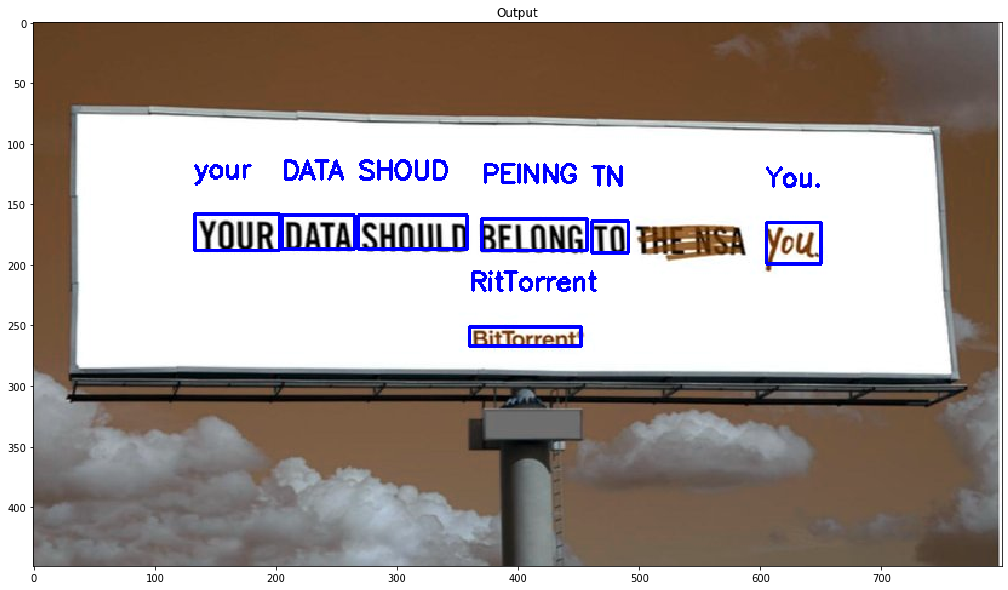

In [14]:
plt.figure(figsize = (25,10))
plt.imshow(orig_image)
plt.title('Output')
plt.show()